## Git log analyse

notebook for parsing git logs and analysing stats (commit dates, lines added, modified files, etc)

Creating logs:
```sh
git log --author="AUTHOR" --oneline --shortstat --numstat --before="2024-01-20" --after="2017-01-01" --pretty=format:"%ai" > mylog
```

In [42]:
from pydantic.dataclasses import dataclass
from typing import List, Iterable, Dict, Optional
from dateutil.parser import isoparse
from datetime import datetime, date, timedelta, time

In [26]:
@dataclass
class FileChange:
    added_lines: int
    removed_lines: int
    file: str
    
    @property
    def file_ext(self) -> str:
        s = self.file.split('.')
        if len(s) == 1: return 'UNKNOWN'
        s = s[-1]
        if s.endswith('}'):
            s = s[:-1]
        return s

@dataclass
class Digest:
    added_lines: int
    removed_lines: int   
    
    @property
    def is_empty(self) -> bool:
        return self.added_lines == 0 and self.removed_lines == 0
    
    def __add__(self, other: 'Digest') -> 'Digest':
        return Digest(self.added_lines + other.added_lines, self.removed_lines + other.removed_lines)
    
@dataclass
class Commit:
    date: datetime
    files: List[FileChange]
    
    def get_digest(self, exts: Iterable[str] = ('java', 'kt')) -> Digest:
        dgst = Digest(0, 0)
        for f in self.files:
            if f.file_ext in exts:
                dgst.added_lines += f.added_lines
                dgst.removed_lines += f.removed_lines
        return dgst

In [27]:
def parse_change(line: str) -> FileChange:
    try:
        add, sub, path = line.split('\t')
        if add == '-':
            add = 0
        if sub == '-':
            sub = 0
        return FileChange(int(add), int(sub), path)
    except ValueError:
        print(f"cannot parse {line}")

def parse_commit(text: str) -> Commit:
    lines = text.strip().split('\n')
    try:
        date = isoparse(' '.join(lines[0].split(' ')[:-1]))
    except ValueError as ex:
        print(f"cannot parse '{lines[0]}' {ex}, text = {text}")
    changes = [parse_change(line) for line in lines[1:-1]]
    return Commit(date, changes)

def load_from_file(path: str) -> List[Commit]:
    with open(path) as f:
        lines = ''.join([line for line in f])
    commits = lines.split('\n\n')
    return [parse_commit(c) for c in commits]

In [4]:
me = load_from_file("mylog")

In [28]:
def group_by_days(commits: List[Commit]) -> Dict[date, Digest]:
    result = {}
    for c in commits:
        d = c.get_digest()
        date = c.date.date()
        result[date] = d + result.get(date, Digest(0, 0))
    return result
    
def group_by_weeks(commits: List[Commit]) -> Dict[date, Digest]:
    result = {}
    for c in commits:
        d = c.get_digest()
        date = c.date.date()
        prev_monday = date - timedelta(days=date.weekday())
        date = prev_monday
        result[date] = d + result.get(date, Digest(0, 0))
    return result

def group_by_hours_and_week(commits: List[Commit]) -> Dict[int, Digest]:
    result = { i: Digest(0, 0) for i in range(24 * 7 + 1) }
    for c in commits:
        d = c.get_digest()
        hour = c.date.time().hour
        day = c.date.date().weekday()
        t = day * 24 + hour
        result[t] = d + result[t]
    return result

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_plt(data: Dict[date, Digest], ylim=1000):
    plt.rcParams["figure.figsize"] = (25, 10)
    
    items = sorted(data.items(), key = lambda x: x[0])
    
    x = [k for k, v in items]
    y1 = [v.added_lines for k, v in items]
    y2 = [v.removed_lines for k, v in items]
    
    locator = mdates.AutoDateLocator()
    
    fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    
    ax.set_ylim(0, ylim)
    plt.bar(x, y1)
    plt.bar(x, y2)
    
    # plt.plot(x, y1)
    # plt.plot(x, y2)
    
    plt.show()

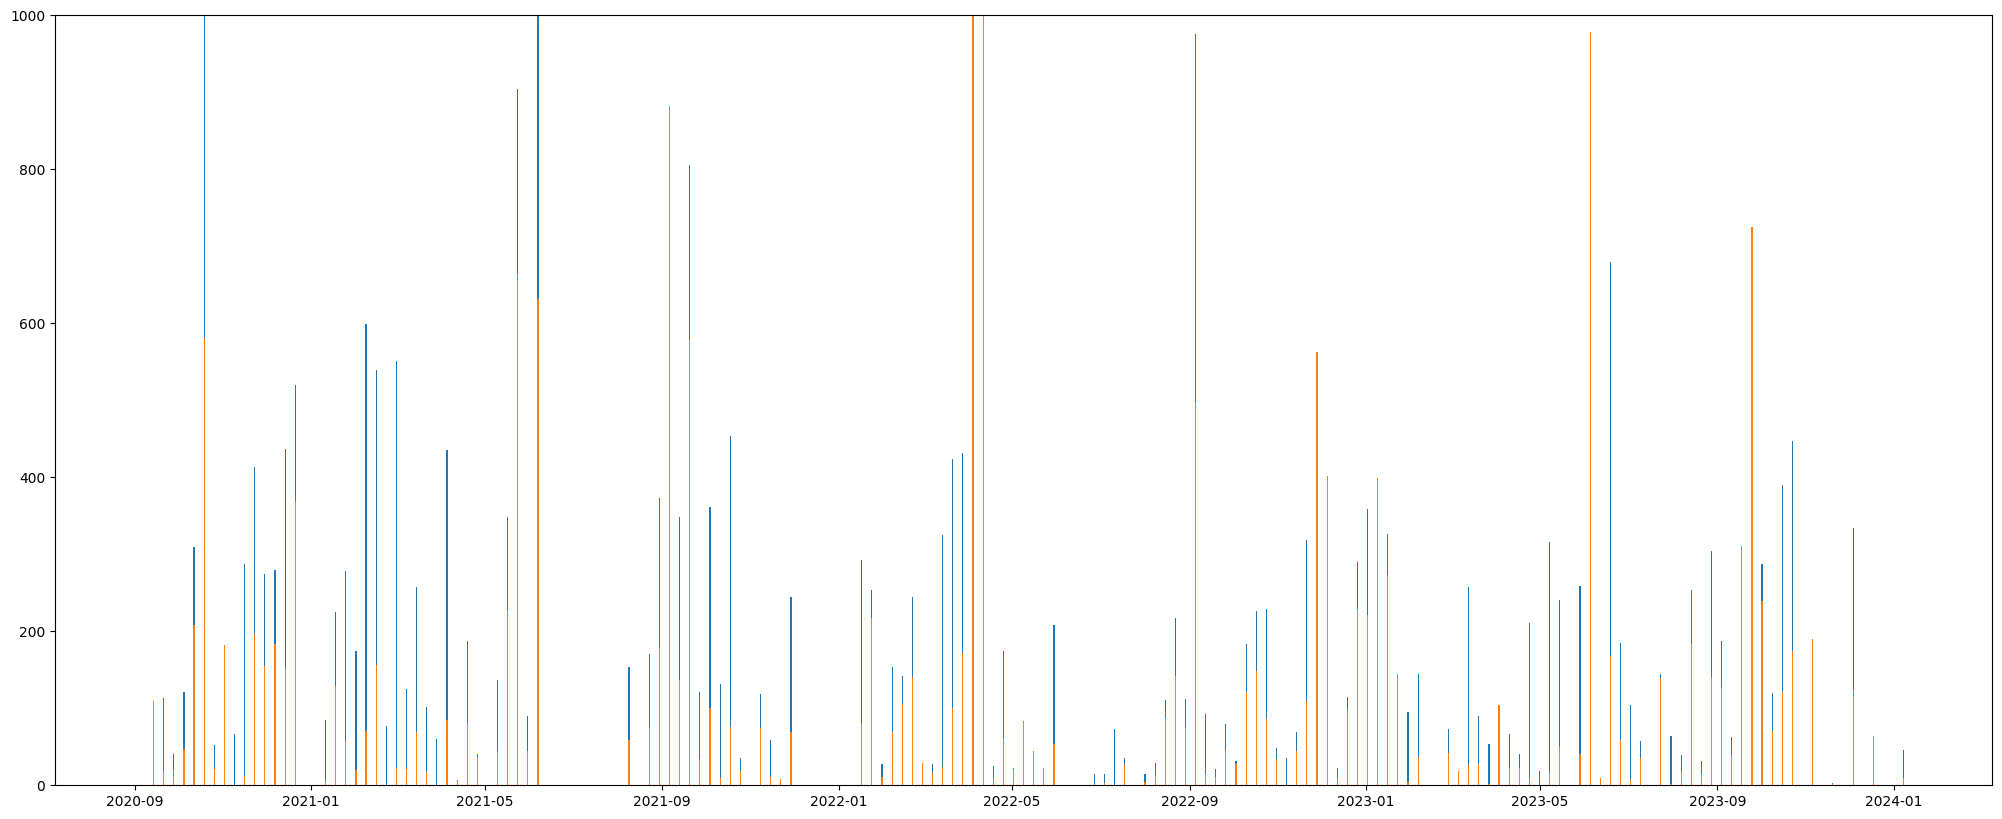

In [30]:
show_plt(group_by_weeks(me))

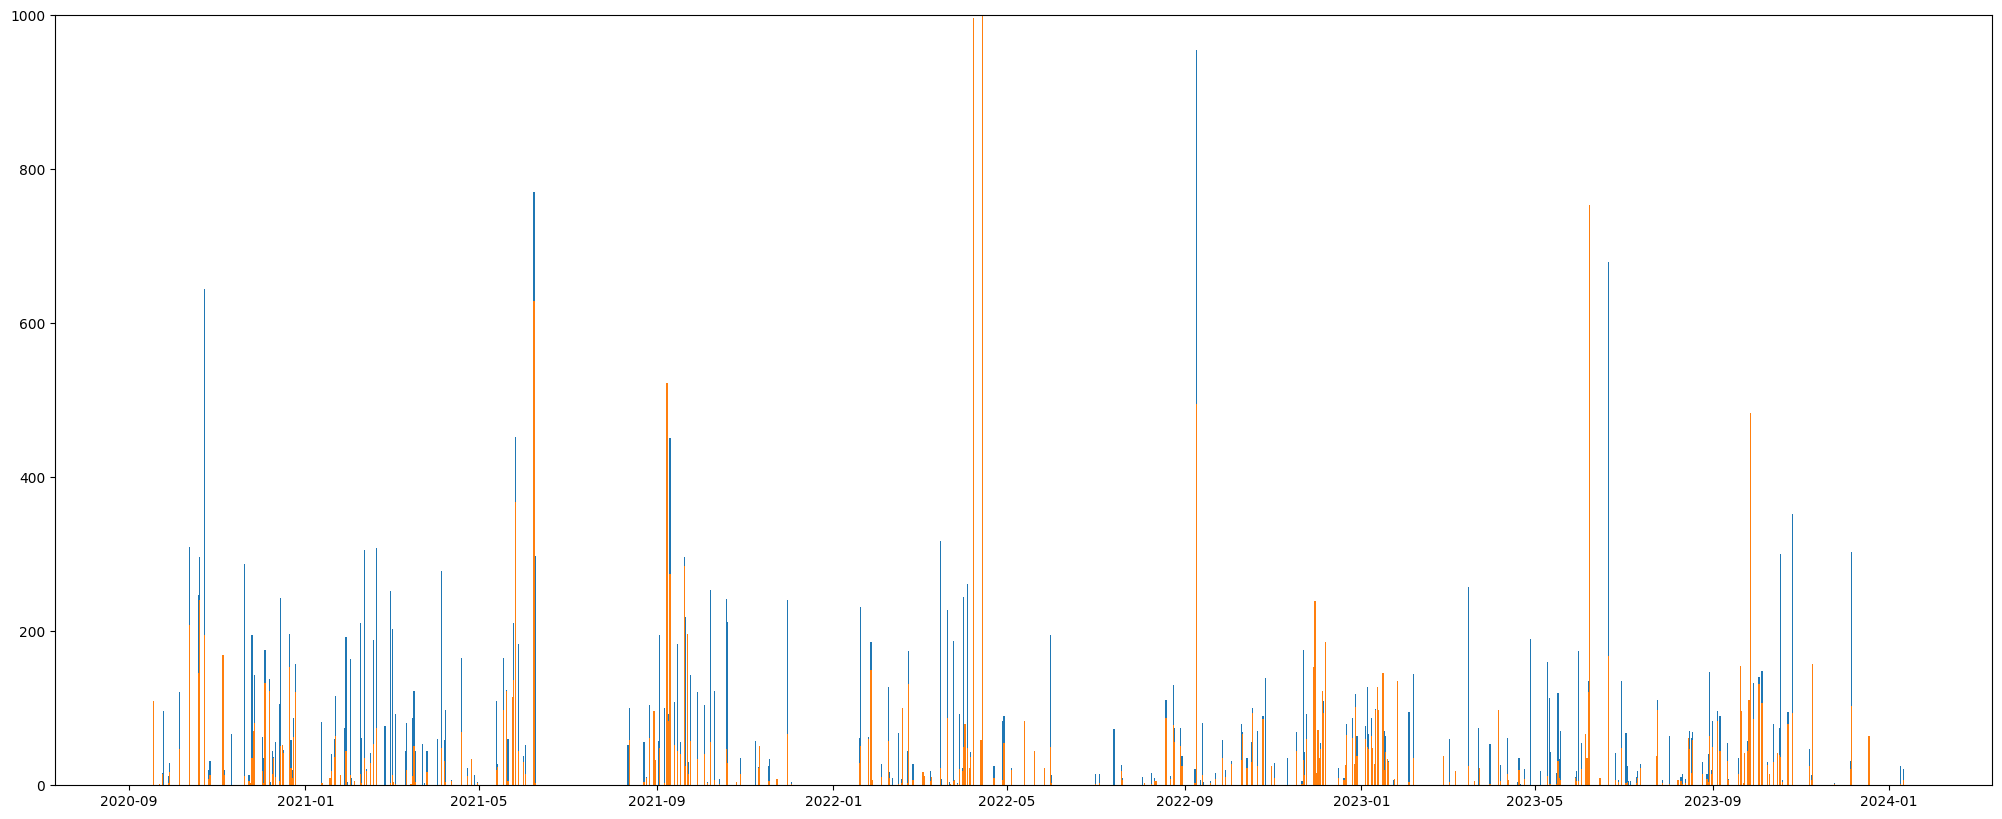

In [31]:
show_plt(group_by_days(me))

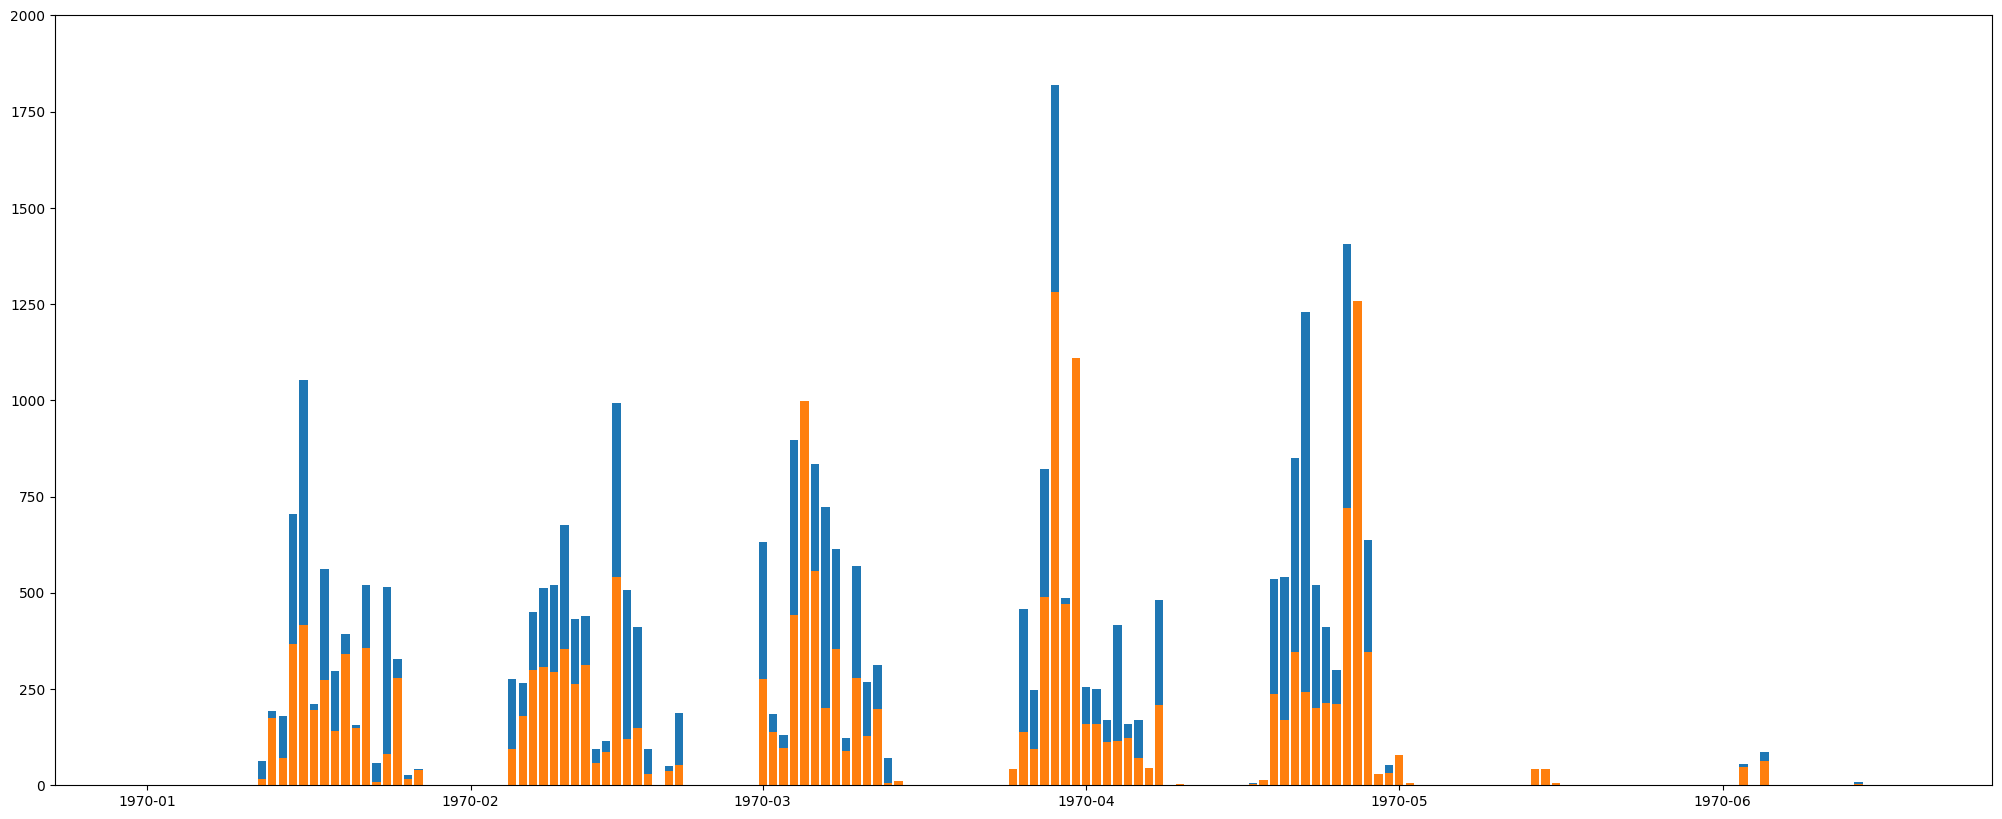

In [40]:
show_plt(group_by_hours_and_week(me), ylim=2000)

In [43]:
def analyse(commits: List[Commit], year: Optional[int] = None):
    added = {}
    removed = {}
    for a in commits:
        if year is None or a.date.year == year:
            for f in a.files:
                ext = f.file_ext
                added[ext] = f.added_lines + added.get(ext, 0)
                removed[ext] = f.removed_lines + removed.get(ext, 0)
            
    print(f'''added = {added}
removed = {removed}
''')

In [44]:
analyse(me, 2023)    

added = {'kt': 7744, 'ipynb': 98, 'xml': 76, 'properties': 12, 'md': 1, 'java': 195, 'bnf': 4, 'flex': 2, 'iml': 20, 'ft': 2, 'txt': 1}
removed = {'kt': 5317, 'ipynb': 1, 'xml': 51, 'properties': 1, 'md': 0, 'java': 83, 'bnf': 4, 'flex': 2, 'iml': 3, 'ft': 1, 'txt': 1}



In [45]:
analyse(me, 2022)

added = {'kt': 9069, 'md': 28, 'properties': 10, 'xml': 141, 'java': 64, 'iml': 2}
removed = {'kt': 6403, 'md': 22, 'properties': 1, 'xml': 102, 'java': 38, 'iml': 1}

